In [1]:
import matplotlib
import pandas as pd
from scripts.common.classification import k_neighbours_leave_one_out
from scripts.common.clustering import *
from scripts.common.outliers import find_outliers_in_multiple_columns, drop_outliers_from_dataset, plot_2d_data_with_outliers
from scripts.common.standardization import standardize, de_standardize

matplotlib.rcParams['figure.figsize'] = [7, 7]

### Constants and settings

In [2]:
perform_silhouette_coefficient_analysis = False
columns_used_for_clustering = ["User_Score", "Critic_Score", "EU_Sales", "NA_Sales", "JP_Sales"]

### Load dataset from file
Please note that the `_preprocessed` file is required. To use this notebook
properly, please execute the preprocessing one first to generate proper dataset
file.

In [3]:
data = pd.read_excel("../data/games_sales_2016_preprocessed.xlsx", index_col=0)
data = data.filter(items=columns_used_for_clustering)

### Data stats for each column

In [4]:
stats_to_compute = ["max", "min", "std", "mean", "median"]
columns_stats = data.agg({item: stats_to_compute for item in columns_used_for_clustering})
print(columns_stats.to_string())

          User_Score  Critic_Score   EU_Sales   NA_Sales   JP_Sales
max     9.600000e+00     99.000000  28.960000  41.360000  10.220000
min     8.881784e-16     13.000000   0.000000   0.000000   0.000000
std     1.302502e+00     12.449705   0.622661   1.002670   0.385861
mean    7.270068e+00     70.941734   0.225307   0.402908   0.108312
median  7.500000e+00     72.400000   0.070000   0.170000   0.000000


### Data standardization

In [5]:
standardize(data, columns_used_for_clustering, columns_stats)

### Outliers detection - 5 dimensions

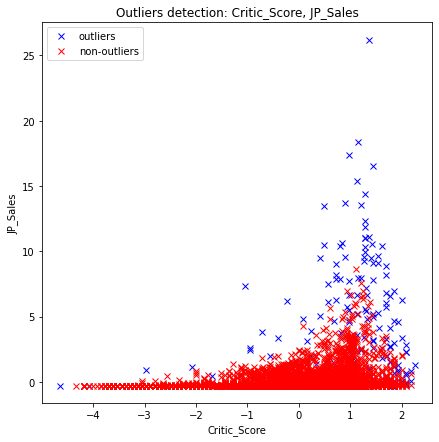

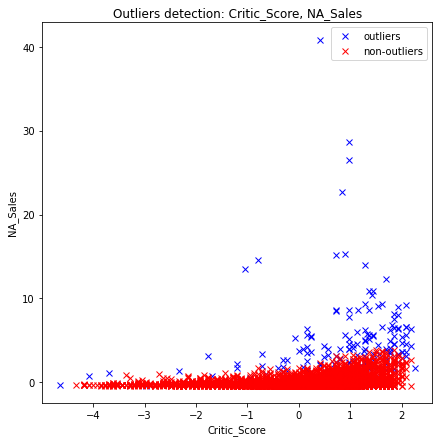

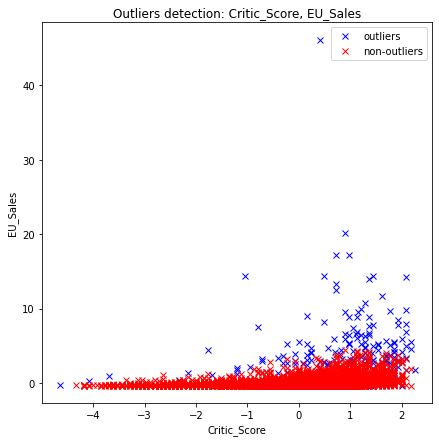

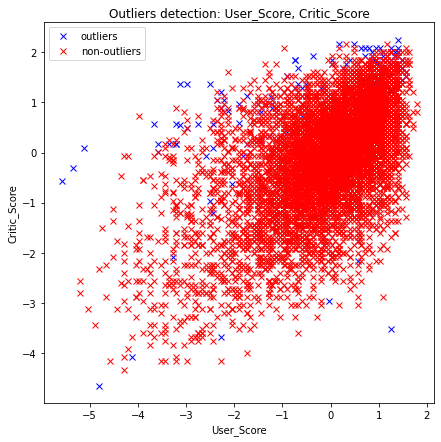

In [6]:
k_neighbours = 5
r_percentage = 0.02
outliers, non_outliers = find_outliers_in_multiple_columns(data, columns_used_for_clustering, k_neighbours, r_percentage)

plot_2d_data_with_outliers(outliers, non_outliers, ("Critic_Score", "JP_Sales"))
plot_2d_data_with_outliers(outliers, non_outliers, ("Critic_Score", "NA_Sales"))
plot_2d_data_with_outliers(outliers, non_outliers, ("Critic_Score", "EU_Sales"))
plot_2d_data_with_outliers(outliers, non_outliers, ("User_Score", "Critic_Score"))

### Clustering - 5 dimensions

First, we perform clustering analysis using the **silhouette** coefficient, to get the optimal number of clusters.
This will take some time ...

In [7]:
if perform_silhouette_coefficient_analysis:
    numbers_of_clusters = list(range(2, 40))
    silhouette_values = []
    for number_of_clusters in numbers_of_clusters:
        data_without_outliers = drop_outliers_from_dataset(data, outliers)
        silhouette_value = k_means_multiple_dim_silhouette(data_without_outliers, columns_used_for_clustering, number_of_clusters)
        print(silhouette_value)
        silhouette_values.append(silhouette_value)
    plt.figure()
    plt.plot(numbers_of_clusters, silhouette_values)
    plt.show()

### Clustering for chosen number of clusters - 5 dimensions

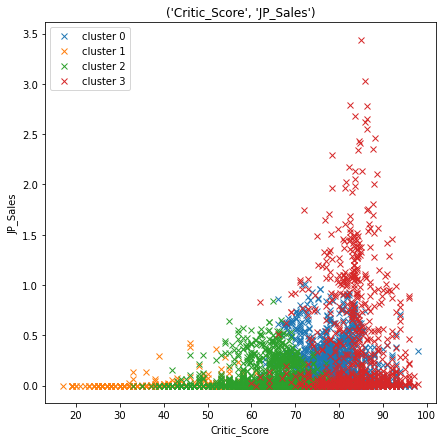

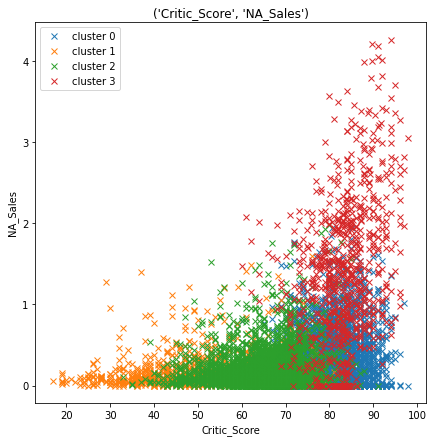

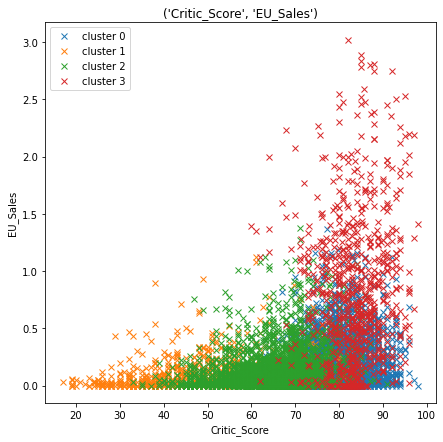

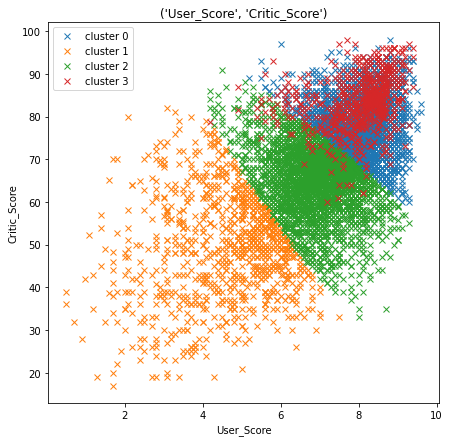

In [8]:
data_without_outliers = drop_outliers_from_dataset(data, outliers)
clustered_data = k_means_multiple_dim_clustering(data_without_outliers, columns_used_for_clustering, 4)

de_standardize(clustered_data, columns_used_for_clustering, columns_stats)
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", "JP_Sales"))
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", "NA_Sales"))
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", "EU_Sales"))
plot_2d_data_with_clusters(clustered_data, ("User_Score", "Critic_Score"))


### Compute and display stats for each cluster

         User_Score  Critic_Score  EU_Sales  NA_Sales  JP_Sales
cluster                                                        
0          8.060649     78.551152  0.139982  0.276984  0.077290
1          4.622230     49.394163  0.082660  0.167282  0.007129
2          6.925481     64.933316  0.107761  0.205041  0.032043
3          8.029116     83.365006  0.800461  1.388182  0.437945


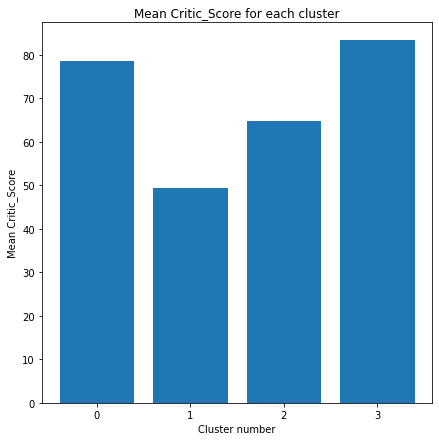

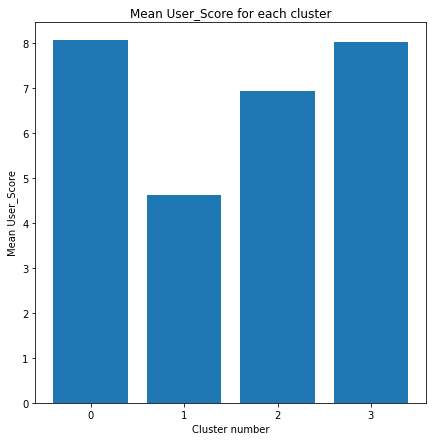

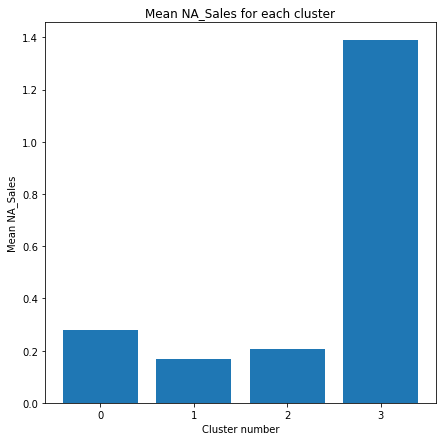

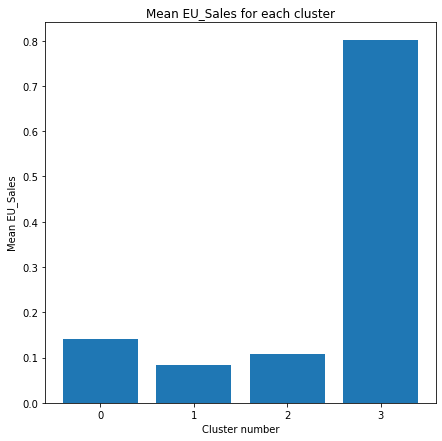

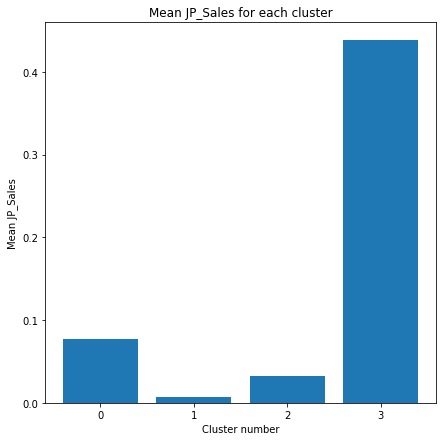

In [9]:
data_means_grouped_by_clusters = clustered_data.groupby("cluster").mean()
print(data_means_grouped_by_clusters)

plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "Critic_Score")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "User_Score")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "NA_Sales")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "EU_Sales")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "JP_Sales")

### Classification to clusters (KNN)
We use the leave-one-out method to monitor classification quality.

In [10]:
standardize(clustered_data, columns_used_for_clustering, columns_stats)
classification_quality, confusion_matrix = k_neighbours_leave_one_out(clustered_data, "cluster", 3)
print(classification_quality)
print(confusion_matrix)


0.9771551303329102
[[4383.    0.   55.   31.]
 [   0. 1026.   19.    0.]
 [  51.   18. 3852.    5.]
 [  50.    0.    5.  748.]]
